### In this notebook we see how increasing the data for each class improves the overall accuracy of the binary classifier made of VGG16. The GANs were trained on the data of each class and generated samples for them.

Showing some generated images from our GANS

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers, Model
import os
import numpy as np
import matplotlib.pyplot as plt


# Set paths to the data
base_dir = os.path.normpath('D:/Generative_AI/VOCtrainval_14-Jul-2008')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Get class names from directory names in train_dir
classes = [dir_name for dir_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, dir_name))]

def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 512, activation="relu", input_dim=latent_dim),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh")
    ])
    return model

def build_discriminator(image_shape):
    model = keras.Sequential([
        layers.InputLayer(input_shape=image_shape),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def schedule(epoch, lr):
    return lr * 0.95 if epoch > 10 else lr

def train_gan(class_name, epochs=50):
    class_train_dir = os.path.join(train_dir, class_name)  # Ensure the path to the specific class directory
    model_dir = os.path.join('models', class_name)
    os.makedirs(model_dir, exist_ok=True)
    print(class_train_dir)
    print(train_dir)
    train_data_generator = ImageDataGenerator(rescale=1.0/255.0)
    train_data_iterator = train_data_generator.flow_from_directory(
    train_dir,  # Use train_dir as the directory
    target_size=(64, 64),
    batch_size=32,
    classes=[class_name],  # Specify the current class being trained
    class_mode='categorical')

    latent_dim = 100
    generator = build_generator(latent_dim)
    discriminator = build_discriminator((64, 64, 3))
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    discriminator.trainable = False
    
    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    # Train the GAN
    for epoch in range(epochs):
        # Real images
        real_images, _ = next(train_data_iterator)
        real_labels = np.ones((real_images.shape[0], 1)) 

        # Noise and fake images
        noise = np.random.normal(0, 1, (real_images.shape[0], latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((fake_images.shape[0], 1))

        # Train discriminator on real and fake
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        discriminator.trainable = False

        # Train generator
        misleading_targets = np.ones((real_images.shape[0], 1))
        g_loss = gan.train_on_batch(noise, misleading_targets)

        print(f'Epoch: {epoch+1}/{epochs}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}')

    # Save models
    generator.save(os.path.join(model_dir, 'generator.h5'))
    discriminator.save(os.path.join(model_dir, 'discriminator.h5'))
    print(f'Models saved for class {class_name}: Generator at {model_dir}/generator.h5, Discriminator at {model_dir}/discriminator.h5')

# Main loop for each class
for class_name in classes:
    train_gan(class_name, epochs=250)

# Set the base directory where the models are saved
base_model_dir = 'D:/Generative_AI/VOCtrainval_14-Jul-2008/models'

# List all class names - assuming each class has its own directory under base_model_dir
class_names = [dir_name for dir_name in os.listdir(base_model_dir) if os.path.isdir(os.path.join(base_model_dir, dir_name))]

def generate_images(generator, num_images, latent_dim):
    """ Generate images using the generator model provided """
    # Generate random noise
    random_latent_vectors = np.random.normal(0, 1, size=(num_images, latent_dim))
    # Generate images from the noise
    generated_images = generator.predict(random_latent_vectors)
    return generated_images

def save_images(images, class_name, base_output_dir):
    """ Save the generated images to a directory specific to the class """
    class_output_dir = os.path.join(base_output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)  # Create directory if it does not exist
    for i, image in enumerate(images):
        # Normalize image from [-1, 1] to [0, 1]
        normalized_image = (image + 1) * 0.5
        # Ensure the image is clipped between 0 and 1 in case of any floating point arithmetic issues
        clipped_image = np.clip(normalized_image, 0, 1)
        # Save the image
        plt.imsave(os.path.join(class_output_dir, f'image_{i+1}.png'), clipped_image)

# Main loop to process each class
for class_name in class_names:
    print(f"Processing class: {class_name}")
    model_dir = os.path.join(base_model_dir, class_name)
    generator_path = os.path.join(model_dir, 'generator.h5')
    
    # Load the generator model
    generator = load_model(generator_path)
    
    # Generate images
    images = generate_images(generator, 500, 100)  # Assuming latent dim is 100 as in previous examples
    
    # Save generated images
    save_images(images, class_name, 'D:/Generative_AI/VOCtrainval_14-Jul-2008/generated_images')



<ipython-input-10-ff5cfdb09b17>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(resize_dimensions, Image.ANTIALIAS)


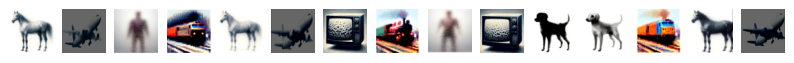

In [10]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Set the path to the directory containing images
image_dir = '/content/generated'

# List all files in the directory
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.PNG')]

# Define the number of images to display and the size to which images should be resized
resize_dimensions = (64, 64)

# Ensure you do not try to display more images than are available
num_images_to_display = min(15, len(image_files))  # Change 5 to however many you'd ideally like to display

if num_images_to_display == 0:
    print("No images found in the directory.")
else:
    # Randomly select images
    selected_images = random.sample(image_files, num_images_to_display)

    # Create a figure to display the images
    plt.figure(figsize=(10, 10))  # Adjust the size as per your preference

    # Loop through the selected images, resize them, and display them
    for i, image_path in enumerate(selected_images):
        img = Image.open(image_path)
        img = img.resize(resize_dimensions, Image.ANTIALIAS)
        plt.subplot(1, num_images_to_display, i + 1)  # Adjust the grid parameters based on your number of images
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbering and ticks

    plt.show()

Datasets have been generated for 100 , 200 and 500 seperately

# Training VGG for 100 images

In [ ]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the paths to the train and test directories
train_folder_path = "/content/train100"

# Each class has its own directory within the train directory
class_names = [d for d in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, d))]

# Create a dictionary to hold our training image paths
train_data_lists = {class_name: [os.path.join(train_folder_path, class_name, img)
                                 for img in os.listdir(os.path.join(train_folder_path, class_name))]
                    for class_name in class_names}

def build_binary_classification_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Configure the ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Loop through each class and train a binary classification model
for class_name in class_names:
    print(f"Training for class: {class_name}")

    # Retrieve the list of image paths for the positive class
    positive_images = train_data_lists[class_name]
    if not positive_images:
        print(f"No images found for class {class_name}. Skipping this class.")
        continue
    positive_labels = [1] * len(positive_images)

    # Build a list of image paths for the negative class (all other classes)
    negative_images = []
    for other_class_name, image_paths in train_data_lists.items():
        if other_class_name != class_name:
            negative_images.extend(image_paths)

    print(f"Number of positive samples for {class_name}: {len(positive_images)}")
    print(f"Number of negative samples before balancing: {len(negative_images)}")


    random.shuffle(negative_images)  # Shuffle the negative images
    negative_images = negative_images[:len(positive_images)]  # Balance the positive and negative datasets
    negative_labels = [0] * len(negative_images)
    print(f"Number of negative samples after balancing: {len(negative_images)}")

    # Combine and shuffle the positive and negative samples
    combined_images = positive_images + negative_images
    combined_labels = positive_labels + negative_labels
    combined_list = list(zip(combined_images, combined_labels))
    random.shuffle(combined_list)
    combined_images, combined_labels = zip(*combined_list)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({
    'filename': X_train,
    'label': [str(label) for label in y_train]  # Convert labels to strings
})
    val_df = pd.DataFrame({
    'filename': X_val,
    'label': [str(label) for label in y_val]  # Convert labels to strings
})

    # Create data generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    #Build the binary classification model
    model = build_binary_classification_model()

    # Train the model on the data
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // 32,
        validation_data=val_generator,
        validation_steps=len(X_val) // 32,
        epochs=10
    )

    # Save the trained model
    model_save_path = os.path.join('models', f"{class_name}_binary_model.h5")
    os.makedirs('models', exist_ok=True)
    model.save(model_save_path)

    print(f"Finished training for class: {class_name}")

Training for class: Cat
Number of positive samples for Cat: 362
Number of negative samples before balancing: 6545
Number of negative samples after balancing: 362
Found 579 validated image filenames belonging to 2 classes.
Found 145 validated image filenames belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711570916.501287      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/18 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4938 - loss: 0.9617  

W0000 00:00:1711570936.761835      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5191 - loss: 0.8871

W0000 00:00:1711570941.792594      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5217 - loss: 0.8812 - val_accuracy: 0.6484 - val_loss: 0.5867
Epoch 2/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.7188 - loss: 0.5770

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7188 - loss: 0.5770 - val_accuracy: 0.7059 - val_loss: 0.5906
Epoch 3/10


W0000 00:00:1711570961.017522      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.6867 - loss: 0.5625 - val_accuracy: 0.6562 - val_loss: 0.5932
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.5134 - val_accuracy: 0.6471 - val_loss: 0.5891
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.7436 - loss: 0.5249 - val_accuracy: 0.7344 - val_loss: 0.5545
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.6533 - val_accuracy: 0.5294 - val_loss: 0.8044
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.6746 - loss: 0.5584 - val_accuracy: 0.7109 - val_loss: 0.5042
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.4272 - val_accuracy: 0.8235 - val_loss: 0.3720
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 0.7845 - loss: 0.4247 - val_accuracy: 0.7109 - val_loss: 0.5479
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.4178 - val_accuracy: 0.6471 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571014.100407      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/10 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.5295 - loss: 0.7479

W0000 00:00:1711571050.326675      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5549 - loss: 0.7680

W0000 00:00:1711571053.809749      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.5553 - loss: 0.7666 - val_accuracy: 0.4531 - val_loss: 0.7341
Epoch 2/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.5312 - loss: 0.6805

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5312 - loss: 0.6805 - val_accuracy: 0.4737 - val_loss: 0.7439
Epoch 3/10


W0000 00:00:1711571074.503574      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.6421 - loss: 0.6428 - val_accuracy: 0.6875 - val_loss: 0.6200
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6562 - loss: 0.5688 - val_accuracy: 0.5789 - val_loss: 0.8273
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 402ms/step - accuracy: 0.6065 - loss: 0.5823 - val_accuracy: 0.6406 - val_loss: 0.6074
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5625 - loss: 0.6379 - val_accuracy: 0.6316 - val_loss: 0.7440
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.6550 - loss: 0.6012 - val_accuracy: 0.6094 - val_loss: 0.6891
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6250 - loss: 0.5143 - val_accuracy: 0.4211 - val_loss: 0.8428
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.7167 - loss: 0.5636 - val_accuracy: 0.5469 - val_loss: 0.8696
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7188 - loss: 0.6686 - val_accuracy: 0.5789 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571113.188959      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.4996 - loss: 0.8278

W0000 00:00:1711571145.198617      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5194 - loss: 0.8053 - val_accuracy: 0.7188 - val_loss: 0.5355
Epoch 2/10


W0000 00:00:1711571146.384614      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.6562 - loss: 0.6293

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.6562 - loss: 0.6293 - val_accuracy: 0.7586 - val_loss: 0.4675
Epoch 3/10


W0000 00:00:1711571175.031345      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - accuracy: 0.6562 - loss: 0.6878 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7500 - loss: 0.5950 - val_accuracy: 0.7500 - val_loss: 0.5275
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.7189 - loss: 0.5963 - val_accuracy: 0.7241 - val_loss: 0.5799
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.3106 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.7621 - loss: 0.5076 - val_accuracy: 0.8125 - val_loss: 0.4280
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.4568 - val_accuracy: 0.7586 - val_loss: 0.4376
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.7752 - loss: 0.5181 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9375 - loss: 0.3766 - val_accuracy: 0.8438 - 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571209.674637      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/9 ━━━━━━━━━━━━━━━━━━━━ 2:49 24s/step - accuracy: 0.5888 - loss: 0.8137

W0000 00:00:1711571234.224046      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5383 - loss: 0.8424

W0000 00:00:1711571238.046211      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5356 - loss: 0.8387 - val_accuracy: 0.5312 - val_loss: 0.7117
Epoch 2/10
1/9 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.5000 - loss: 0.7512

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5000 - loss: 0.7512 - val_accuracy: 0.6000 - val_loss: 0.6834
Epoch 3/10


W0000 00:00:1711571250.798737      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.6117 - loss: 0.6532 - val_accuracy: 0.6094 - val_loss: 0.6394
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6562 - loss: 0.6257 - val_accuracy: 0.7000 - val_loss: 0.5908
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - accuracy: 0.6699 - loss: 0.5983 - val_accuracy: 0.5938 - val_loss: 0.6632
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 0.6633 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.6076 - loss: 0.6695 - val_accuracy: 0.5312 - val_loss: 0.6755
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 0.6767 - val_accuracy: 0.5000 - val_loss: 0.6867
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.6502 - loss: 0.6478 - val_accuracy: 0.5625 - val_loss: 0.6631
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7188 - loss: 0.5501 - val_accuracy: 0.8000 - val_loss: 0.5401
Finished t

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571354.679989      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/12 ━━━━━━━━━━━━━━━━━━━━ 14:02 77s/step - accuracy: 0.4643 - loss: 0.7181

W0000 00:00:1711571357.291683      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.5419 - loss: 0.8757

W0000 00:00:1711571362.484510      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 703ms/step - accuracy: 0.5421 - loss: 0.8685 - val_accuracy: 0.5625 - val_loss: 0.6925
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - accuracy: 0.5000 - loss: 0.7061

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 883ms/step - accuracy: 0.5000 - loss: 0.7061 - val_accuracy: 0.7500 - val_loss: 0.5664
Epoch 3/10


W0000 00:00:1711571372.894466      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.4850 - loss: 0.7178 - val_accuracy: 0.4479 - val_loss: 0.7046
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4286 - loss: 0.7080 - val_accuracy: 0.2500 - val_loss: 0.7212
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.5426 - loss: 0.6882 - val_accuracy: 0.5833 - val_loss: 0.6767
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6071 - loss: 0.6630 - val_accuracy: 0.2500 - val_loss: 0.8170
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.5006 - loss: 0.7044 - val_accuracy: 0.5729 - val_loss: 0.6901
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6985
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.5551 - loss: 0.6859 - val_accuracy: 0.6875 - val_loss: 0.6824
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.6750 - val_accuracy: 0.3750 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571417.140117      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6186 - loss: 0.6734

W0000 00:00:1711571462.277415      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 57s 563ms/step - accuracy: 0.6187 - loss: 0.6730 - val_accuracy: 0.6369 - val_loss: 0.6182
Epoch 2/10
 1/85 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 0.7500 - loss: 0.5503

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7500 - loss: 0.5503 - val_accuracy: 0.6667 - val_loss: 0.6861
Epoch 3/10


W0000 00:00:1711571476.328152      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.6623 - loss: 0.6200 - val_accuracy: 0.6354 - val_loss: 0.6155
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.7812 - loss: 0.5221 - val_accuracy: 0.8889 - val_loss: 0.4870
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 428ms/step - accuracy: 0.6856 - loss: 0.5949 - val_accuracy: 0.6473 - val_loss: 0.6047
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.6250 - loss: 0.6696 - val_accuracy: 0.6667 - val_loss: 0.7906
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 423ms/step - accuracy: 0.6648 - loss: 0.6126 - val_accuracy: 0.6503 - val_loss: 0.6055
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.5625 - loss: 0.6710 - val_accuracy: 0.6667 - val_loss: 0.4902
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.6807 - loss: 0.6015 - val_accuracy: 0.6562 - val_loss: 0.6038
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.7812 - loss: 0.5761 - val_accuracy: 0.7778 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571644.799887      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 4/13 ━━━━━━━━━━━━━━━━━━━━ 1:02 7s/step - accuracy: 0.5460 - loss: 0.8535 

W0000 00:00:1711571666.021081      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5414 - loss: 0.8163

W0000 00:00:1711571670.660013      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5432 - loss: 0.8122 - val_accuracy: 0.6146 - val_loss: 0.6784
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.5938 - loss: 0.6796

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5938 - loss: 0.6796 - val_accuracy: 0.9000 - val_loss: 0.4975
Epoch 3/10


W0000 00:00:1711571671.847429      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.5519 - loss: 0.6925 - val_accuracy: 0.6979 - val_loss: 0.6604
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6250 - loss: 0.6568 - val_accuracy: 0.8000 - val_loss: 0.5918
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step - accuracy: 0.6503 - loss: 0.6456 - val_accuracy: 0.7188 - val_loss: 0.6136
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.4086 - val_accuracy: 0.9000 - val_loss: 0.4654
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 433ms/step - accuracy: 0.5889 - loss: 0.6314 - val_accuracy: 0.6771 - val_loss: 0.6082
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.5709 - val_accuracy: 0.7000 - val_loss: 0.7489
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.6856 - loss: 0.5801 - val_accuracy: 0.7188 - val_loss: 0.5924
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.5267 - val_accuracy: 0.6000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571717.178711      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5624 - loss: 0.8048

W0000 00:00:1711571721.619044      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 532ms/step - accuracy: 0.5593 - loss: 0.8010 - val_accuracy: 0.4688 - val_loss: 0.7091
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6392
Epoch 3/10


W0000 00:00:1711571722.257669      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.5491 - loss: 0.6739 - val_accuracy: 0.5781 - val_loss: 0.7113
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6450
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.6273 - loss: 0.6410 - val_accuracy: 0.7031 - val_loss: 0.6150
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5073
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.7042 - loss: 0.5655 - val_accuracy: 0.7969 - val_loss: 0.4391
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3703
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - accuracy: 0.7146 - loss: 0.5398 - val_accuracy: 0.7812 - val_loss: 0.5399
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.25

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571759.352243      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 6/12 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.5259 - loss: 0.9273

W0000 00:00:1711571814.755423      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5330 - loss: 0.8436

W0000 00:00:1711571817.850344      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.5327 - loss: 0.8361 - val_accuracy: 0.5833 - val_loss: 0.6850
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.3750 - loss: 0.7898

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3750 - loss: 0.7898 - val_accuracy: 0.5000 - val_loss: 0.7044
Epoch 3/10


W0000 00:00:1711571819.102821      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.4764 - loss: 0.7034 - val_accuracy: 0.4167 - val_loss: 0.7551
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4688 - loss: 0.7270 - val_accuracy: 0.5000 - val_loss: 0.7058
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.5224 - loss: 0.6956 - val_accuracy: 0.4583 - val_loss: 0.6964
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 0.6889 - val_accuracy: 0.6667 - val_loss: 0.6882
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.5511 - loss: 0.6885 - val_accuracy: 0.4479 - val_loss: 0.6986
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6562 - loss: 0.6391 - val_accuracy: 0.6667 - val_loss: 0.6800
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.6059 - loss: 0.6591 - val_accuracy: 0.7292 - val_loss: 0.6183
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4688 - loss: 0.7020 - val_accuracy: 0.3333 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571861.581381      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/14 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.5793 - loss: 0.6737

W0000 00:00:1711571903.313635      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5913 - loss: 0.6603 

W0000 00:00:1711571905.354552      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5945 - loss: 0.6564 - val_accuracy: 0.7500 - val_loss: 0.5326
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.7188 - loss: 0.5538

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7188 - loss: 0.5538 - val_accuracy: 0.7000 - val_loss: 0.4758
Epoch 3/10


W0000 00:00:1711571906.622061      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.7383 - loss: 0.4880 - val_accuracy: 0.7292 - val_loss: 0.5302
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5938 - loss: 0.6280 - val_accuracy: 0.8000 - val_loss: 0.4710
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.7383 - loss: 0.4566 - val_accuracy: 0.7708 - val_loss: 0.6459
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7812 - loss: 0.4679 - val_accuracy: 0.7000 - val_loss: 0.6551
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.7398 - loss: 0.4839 - val_accuracy: 0.7188 - val_loss: 0.5852
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9167 - loss: 0.2034 - val_accuracy: 0.8500 - val_loss: 0.2832
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.8493 - loss: 0.3243 - val_accuracy: 0.7083 - val_loss: 0.4849
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7500 - loss: 0.4380 - val_accuracy: 1.0000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711571953.088263      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4937 - loss: 0.7840

W0000 00:00:1711571958.380502      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 508ms/step - accuracy: 0.4921 - loss: 0.7816 - val_accuracy: 0.5312 - val_loss: 0.6846
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.6991
Epoch 3/10


W0000 00:00:1711571982.721479      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.5429 - loss: 0.6924 - val_accuracy: 0.5312 - val_loss: 0.6845
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4583 - val_loss: 0.7069
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.5249 - loss: 0.6875 - val_accuracy: 0.5469 - val_loss: 0.6452
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.7084
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - accuracy: 0.5586 - loss: 0.6599 - val_accuracy: 0.5625 - val_loss: 0.6411
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5417 - val_loss: 0.6586
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.6959 - loss: 0.6217 - val_accuracy: 0.6719 - val_loss: 0.5787
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572023.586427      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/14 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.4219 - loss: 0.9128

W0000 00:00:1711572082.153071      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4845 - loss: 0.8627

W0000 00:00:1711572087.729426      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.4881 - loss: 0.8565 - val_accuracy: 0.4167 - val_loss: 0.7417
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.5312 - loss: 0.6619

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5312 - loss: 0.6619 - val_accuracy: 0.5455 - val_loss: 0.6836
Epoch 3/10


W0000 00:00:1711572088.982528      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.5475 - loss: 0.7045 - val_accuracy: 0.5729 - val_loss: 0.6811
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 0.6830 - val_accuracy: 0.5455 - val_loss: 0.6831
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.5927 - loss: 0.6808 - val_accuracy: 0.5104 - val_loss: 0.7057
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 0.6925 - val_accuracy: 0.5455 - val_loss: 0.6553
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.5952 - loss: 0.6641 - val_accuracy: 0.5104 - val_loss: 0.6866
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5938 - loss: 0.6255 - val_accuracy: 0.5455 - val_loss: 0.6681
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.6464 - loss: 0.6427 - val_accuracy: 0.6667 - val_loss: 0.6096
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7188 - loss: 0.5866 - val_accuracy: 0.6364 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572136.108766      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5623 - loss: 0.7461   

W0000 00:00:1711572159.344049      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711572160.500477      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5626 - loss: 0.7441 - val_accuracy: 0.7083 - val_loss: 0.6221
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.7500 - loss: 0.5905

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7500 - loss: 0.5905 - val_accuracy: 0.5000 - val_loss: 0.6290
Epoch 3/10


W0000 00:00:1711572161.654392      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - accuracy: 0.6431 - loss: 0.6678 - val_accuracy: 0.7083 - val_loss: 0.5174
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.4297 - val_accuracy: 0.6000 - val_loss: 1.0867
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.6638 - loss: 0.6294 - val_accuracy: 0.7396 - val_loss: 0.6389
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.6295 - val_accuracy: 0.9000 - val_loss: 0.4935
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.6377 - loss: 0.5948 - val_accuracy: 0.7396 - val_loss: 0.5202
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.4879 - val_accuracy: 0.7000 - val_loss: 0.6937
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.7162 - loss: 0.5238 - val_accuracy: 0.7188 - val_loss: 0.5661
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.6184 - val_accuracy: 0.7000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572206.299000      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/23 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.5103 - loss: 0.8133

W0000 00:00:1711572246.461983      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5145 - loss: 0.8027 

W0000 00:00:1711572248.436425      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5157 - loss: 0.7997 - val_accuracy: 0.5000 - val_loss: 0.7348
Epoch 2/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.4062 - loss: 0.8562

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 0.8562 - val_accuracy: 0.6207 - val_loss: 0.6484
Epoch 3/10


W0000 00:00:1711572249.910416      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 416ms/step - accuracy: 0.5411 - loss: 0.6856 - val_accuracy: 0.7063 - val_loss: 0.6072
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5938 - loss: 0.6892 - val_accuracy: 0.6207 - val_loss: 0.6560
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.6326 - loss: 0.6430 - val_accuracy: 0.6500 - val_loss: 0.6247
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6250 - loss: 0.6460 - val_accuracy: 0.6207 - val_loss: 0.6153
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 432ms/step - accuracy: 0.6974 - loss: 0.6070 - val_accuracy: 0.7000 - val_loss: 0.6527
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.6252 - val_accuracy: 0.5517 - val_loss: 0.6650
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.5832 - loss: 0.6709 - val_accuracy: 0.6750 - val_loss: 0.5888
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.5699 - val_accuracy: 0.7241 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572346.335240      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/7 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.4531 - loss: 0.8992

W0000 00:00:1711572419.933160      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4669 - loss: 0.8801 

W0000 00:00:1711572422.802455      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 87s 13s/step - accuracy: 0.4682 - loss: 0.8708 - val_accuracy: 0.5781 - val_loss: 0.8528
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 0.7638 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step - accuracy: 0.6923 - loss: 0.6264 - val_accuracy: 0.5469 - val_loss: 0.8443
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.6363 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 440ms/step - accuracy: 0.7362 - loss: 0.5886 - val_accuracy: 0.5625 - val_loss: 0.6771
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.5744 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 436ms/step - accuracy: 0.7163 - loss: 0.5697 - val_accuracy: 0.6875 - val_loss: 0.5927
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.4794 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.7485 - loss: 0.5261 - val_accuracy: 0.7500 - val_loss: 0.5752
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.5969 - val_accuracy: 0.0000e+00 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572458.933041      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/17 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.4971 - loss: 0.7963

W0000 00:00:1711572466.395120      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4991 - loss: 0.7859

W0000 00:00:1711572468.703270      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 613ms/step - accuracy: 0.4996 - loss: 0.7830 - val_accuracy: 0.4609 - val_loss: 0.6838
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.3438 - loss: 0.7488

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3438 - loss: 0.7488 - val_accuracy: 0.5000 - val_loss: 0.6855
Epoch 3/10


W0000 00:00:1711572470.035750      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.5559 - loss: 0.6856 - val_accuracy: 0.5469 - val_loss: 0.7028
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6250 - loss: 0.5998 - val_accuracy: 0.7000 - val_loss: 0.5800
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.6593 - loss: 0.5892 - val_accuracy: 0.6250 - val_loss: 0.6579
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 0.5560 - val_accuracy: 0.4000 - val_loss: 0.6322
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.6162 - loss: 0.6177 - val_accuracy: 0.4922 - val_loss: 0.7070
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4375 - loss: 0.7144 - val_accuracy: 0.3000 - val_loss: 0.6875
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.5996 - loss: 0.6635 - val_accuracy: 0.3906 - val_loss: 0.8267
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6250 - loss: 0.6743 - val_accuracy: 0.6000 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572522.264415      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.4942 - loss: 0.8066

W0000 00:00:1711572528.404535      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.4947 - loss: 0.8019

W0000 00:00:1711572529.868858      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 685ms/step - accuracy: 0.4951 - loss: 0.7979 - val_accuracy: 0.4688 - val_loss: 0.7129
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.5938 - loss: 0.6756

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.5938 - loss: 0.6756 - val_accuracy: 0.5000 - val_loss: 0.6867
Epoch 3/10


W0000 00:00:1711572535.223115      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step - accuracy: 0.5191 - loss: 0.6958 - val_accuracy: 0.5104 - val_loss: 0.6921
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.6647 - val_accuracy: 1.0000 - val_loss: 0.6227
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.4794 - loss: 0.6959 - val_accuracy: 0.5417 - val_loss: 0.6854
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 0.6817 - val_accuracy: 0.5000 - val_loss: 0.7250
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 413ms/step - accuracy: 0.5585 - loss: 0.6882 - val_accuracy: 0.4896 - val_loss: 0.7102
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.6595 - val_accuracy: 0.0000e+00 - val_loss: 0.9641
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.4975 - loss: 0.7028 - val_accuracy: 0.5625 - val_loss: 0.6835
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.6723 - val_accuracy: 1.0000 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572577.617179      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 4/13 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - accuracy: 0.5371 - loss: 0.9297

W0000 00:00:1711572581.408187      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.5546 - loss: 0.8453

W0000 00:00:1711572585.768620      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 671ms/step - accuracy: 0.5543 - loss: 0.8398 - val_accuracy: 0.5625 - val_loss: 0.6721
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.6250 - loss: 0.6559

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6250 - loss: 0.6559 - val_accuracy: 0.7692 - val_loss: 0.5718
Epoch 3/10


W0000 00:00:1711572601.187788      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.6280 - loss: 0.6724 - val_accuracy: 0.5000 - val_loss: 0.6854
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 0.7277 - val_accuracy: 0.6154 - val_loss: 0.6074
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.6130 - loss: 0.6178 - val_accuracy: 0.6042 - val_loss: 0.6601
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5000 - loss: 0.7205 - val_accuracy: 0.6154 - val_loss: 0.6381
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.5477 - loss: 0.6822 - val_accuracy: 0.6979 - val_loss: 0.6172
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 0.6805 - val_accuracy: 0.6154 - val_loss: 0.6700
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - accuracy: 0.6295 - loss: 0.6252 - val_accuracy: 0.6458 - val_loss: 0.6078
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5335 - val_accuracy: 0.4615 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572646.460872      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/20 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.5361 - loss: 0.7658

W0000 00:00:1711572694.112199      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5232 - loss: 0.7370

W0000 00:00:1711572699.521955      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.5224 - loss: 0.7358 - val_accuracy: 0.4938 - val_loss: 0.6950
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step - accuracy: 0.5625 - loss: 0.6915

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5625 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.7055
Epoch 3/10


W0000 00:00:1711572701.025577      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.5049 - loss: 0.6936 - val_accuracy: 0.5063 - val_loss: 0.6917
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 0.7054 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - accuracy: 0.5103 - loss: 0.6916 - val_accuracy: 0.5938 - val_loss: 0.6667
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6601 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 427ms/step - accuracy: 0.5396 - loss: 0.6947 - val_accuracy: 0.5188 - val_loss: 0.6932
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.4829 - loss: 0.6935 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 0.6934 - val_accuracy: 0.7500 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711572766.768344      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5681 - loss: 0.6950

W0000 00:00:1711572775.406732      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step - accuracy: 0.5661 - loss: 0.6953 - val_accuracy: 0.5625 - val_loss: 0.6887
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.6896
Epoch 3/10


W0000 00:00:1711572776.301141      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.5216 - loss: 0.6947 - val_accuracy: 0.5234 - val_loss: 0.6818
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4583 - val_loss: 0.6790
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.5617 - loss: 0.6791 - val_accuracy: 0.5391 - val_loss: 0.6776
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6626
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 427ms/step - accuracy: 0.6542 - loss: 0.6205 - val_accuracy: 0.7266 - val_loss: 0.5977
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.5503
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.7197 - loss: 0.5359 - val_accuracy: 0.6875 - val_loss: 0.6185
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

In [ ]:
import os
import shutil

# Define the path to the train directory
train_dir = "/content/test100"

# Iterate over each subfolder in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(class_dir):
        # Define the path to the subsubfolder
        subsubfolder_dir = os.path.join(class_dir, class_name)

        # Check if the subsubfolder exists
        if os.path.exists(subsubfolder_dir):
            # Iterate over each file in the subsubfolder
            for file_name in os.listdir(subsubfolder_dir):
                file_path = os.path.join(subsubfolder_dir, file_name)

                # Move the file to the parent subfolder
                if os.path.isfile(file_path):
                    shutil.move(file_path, class_dir)

            # Remove the empty subsubfolder
            os.rmdir(subsubfolder_dir)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

model_dir = '/content/models100'
test_data_dir = '/content/test100'

# Initialize ImageDataGenerator for preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Store average precision scores for mAP calculation
ap_scores = []

# Loop through each model file in the models directory
for model_file in sorted(os.listdir(model_dir)):
    if model_file.endswith(".h5"):
        print(f"\nLoading model {model_file}...")
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)
        class_name = model_file.replace("_binary_model.h5", "")
        print(f"Model for class '{class_name}' loaded successfully.")

        # Create DataFrame for test data with labels as strings
        images = []
        labels = []
        for folder in os.listdir(test_data_dir):
            folder_path = os.path.join(test_data_dir, folder)
            for image_file in os.listdir(folder_path):
                images.append(os.path.join(folder, image_file))
                labels.append(str(int(folder == class_name)))  # Convert boolean to int to string

        test_df = pd.DataFrame({
            'filename': images,
            'label': labels  # Labels are now strings
        })

        # Prepare test generator
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_data_dir,
            x_col='filename',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False)

        # Predict and evaluate
        predictions = model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)))

        predicted_labels = (predictions > 0.5).astype(int)
        ap_score = average_precision_score(test_generator.classes, predictions)
        ap_scores.append(ap_score)
        #print(f"AP score for class '{class_name}': {ap_score:.3f}")





In [11]:
# Calculate mean Average Precision (mAP)
mAP = np.mean(ap_scores)
print(f"\nMean Average Precision (mAP) across all classes: {mAP:.3f}")

0.145


# Now for 200 samples

In [ ]:
import os
import shutil

# Define the train folder path
train_folder = '/content/train200'

# Iterate through each class subfolder in the train folder
for class_folder in os.listdir(train_folder):
    class_subfolder = os.path.join(train_folder, class_folder)

    # Ensure it's a directory
    if os.path.isdir(class_subfolder):
        # Get the path of the second subfolder
        second_subfolder = os.path.join(class_subfolder, class_folder)

        # Ensure the second subfolder exists
        if os.path.exists(second_subfolder):
            # Move images from the second subfolder to the first subfolder
            for image_file in os.listdir(second_subfolder):
                src_path = os.path.join(second_subfolder, image_file)
                dest_path = os.path.join(class_subfolder, image_file)
                shutil.move(src_path, dest_path)
                print(f"Moved {image_file} from {second_subfolder} to {class_subfolder}")

            # Remove the second subfolder
            os.rmdir(second_subfolder)
            print(f"Removed {second_subfolder}")


In [ ]:
# Loop through each class and train a binary classification model
for class_name in class_names:
    print(f"Training for class: {class_name}")

    # Retrieve the list of image paths for the positive class
    positive_images = train_data_lists[class_name]
    if not positive_images:
        print(f"No images found for class {class_name}. Skipping this class.")
        continue
    positive_labels = [1] * len(positive_images)

    # Build a list of image paths for the negative class (all other classes)
    negative_images = []
    for other_class_name, image_paths in train_data_lists.items():
        if other_class_name != class_name:
            negative_images.extend(image_paths)

    print(f"Number of positive samples for {class_name}: {len(positive_images)}")
    print(f"Number of negative samples before balancing: {len(negative_images)}")


    random.shuffle(negative_images)  # Shuffle the negative images
    negative_images = negative_images[:len(positive_images)]  # Balance the positive and negative datasets
    negative_labels = [0] * len(negative_images)
    print(f"Number of negative samples after balancing: {len(negative_images)}")

    # Combine and shuffle the positive and negative samples
    combined_images = positive_images + negative_images
    combined_labels = positive_labels + negative_labels
    combined_list = list(zip(combined_images, combined_labels))
    random.shuffle(combined_list)
    combined_images, combined_labels = zip(*combined_list)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({
    'filename': X_train,
    'label': [str(label) for label in y_train]  # Convert labels to strings
})
    val_df = pd.DataFrame({
    'filename': X_val,
    'label': [str(label) for label in y_val]  # Convert labels to strings
})

    # Create data generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    #Build the binary classification model
    model = build_binary_classification_model()

    # Train the model on the data
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // 32,
        validation_data=val_generator,
        validation_steps=len(X_val) // 32,
        epochs=10
    )

    # Save the trained model
    model_save_path = os.path.join('models', f"{class_name}_binary_model.h5")
    os.makedirs('models2', exist_ok=True)
    model.save(model_save_path)

    print(f"Finished training for class: {class_name}")

Training for class: Cat
Number of positive samples for Cat: 362
Number of negative samples before balancing: 6545
Number of negative samples after balancing: 362
Found 579 validated image filenames belonging to 2 classes.
Found 145 validated image filenames belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574127.402241      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/18 ━━━━━━━━━━━━━━━━━━━━ 11s 884ms/step - accuracy: 0.5273 - loss: 0.7811

W0000 00:00:1711574131.296019      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5222 - loss: 0.7661

W0000 00:00:1711574137.395853      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.5223 - loss: 0.7644 - val_accuracy: 0.5312 - val_loss: 0.6899
Epoch 2/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - accuracy: 0.3438 - loss: 0.7563

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3438 - loss: 0.7563 - val_accuracy: 0.5294 - val_loss: 0.6874
Epoch 3/10


W0000 00:00:1711574138.662644      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - accuracy: 0.5359 - loss: 0.6836 - val_accuracy: 0.4844 - val_loss: 0.7002
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3750 - loss: 0.7556 - val_accuracy: 0.3529 - val_loss: 0.7069
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - accuracy: 0.6469 - loss: 0.6623 - val_accuracy: 0.5156 - val_loss: 0.8700
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 0.9322 - val_accuracy: 0.6471 - val_loss: 0.6387
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.5538 - loss: 0.7076 - val_accuracy: 0.8047 - val_loss: 0.6521
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 0.6698 - val_accuracy: 0.5882 - val_loss: 0.6753
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.6570 - loss: 0.6303 - val_accuracy: 0.5156 - val_loss: 0.7166
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 0.7945 - val_accuracy: 0.5294 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574192.403895      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/10 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.5156 - loss: 0.7867

W0000 00:00:1711574195.657187      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5453 - loss: 0.7546

W0000 00:00:1711574199.034521      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 712ms/step - accuracy: 0.5478 - loss: 0.7511 - val_accuracy: 0.5156 - val_loss: 0.7254
Epoch 2/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.5312 - loss: 0.6835

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5312 - loss: 0.6835 - val_accuracy: 0.5263 - val_loss: 0.7311
Epoch 3/10


W0000 00:00:1711574200.053993      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 401ms/step - accuracy: 0.6701 - loss: 0.6593 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5312 - loss: 0.6950 - val_accuracy: 0.6842 - val_loss: 0.6585
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - accuracy: 0.5471 - loss: 0.6963 - val_accuracy: 0.5312 - val_loss: 0.7081
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7273 - loss: 0.6293 - val_accuracy: 0.5263 - val_loss: 0.7712
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.6656 - loss: 0.6357 - val_accuracy: 0.5469 - val_loss: 0.7262
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6562 - loss: 0.5929 - val_accuracy: 0.4737 - val_loss: 0.7639
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step - accuracy: 0.7086 - loss: 0.5863 - val_accuracy: 0.5781 - val_loss: 0.7250
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7500 - loss: 0.4971 - val_accuracy: 0.6842 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574238.418736      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/7 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - accuracy: 0.4635 - loss: 0.8472

W0000 00:00:1711574241.748669      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - accuracy: 0.5366 - loss: 0.7779 - val_accuracy: 0.6875 - val_loss: 0.6893
Epoch 2/10


W0000 00:00:1711574244.055770      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.6875 - loss: 0.7131

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6875 - loss: 0.7131 - val_accuracy: 0.6207 - val_loss: 0.6349
Epoch 3/10


W0000 00:00:1711574244.939538      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.6870 - loss: 0.6138 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7188 - loss: 0.5545 - val_accuracy: 0.6250 - val_loss: 0.6670
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step - accuracy: 0.7564 - loss: 0.5587 - val_accuracy: 0.8276 - val_loss: 0.5386
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.5703 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - accuracy: 0.7888 - loss: 0.4375 - val_accuracy: 0.7812 - val_loss: 0.5118
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.4915 - val_accuracy: 0.6897 - val_loss: 0.6070
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.7879 - loss: 0.4753 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8125 - loss: 0.3940 - val_accuracy: 0.8125 - 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574278.080256      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.4918 - loss: 0.8128

W0000 00:00:1711574283.027690      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.4927 - loss: 0.8090

W0000 00:00:1711574284.471493      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 772ms/step - accuracy: 0.4935 - loss: 0.8059 - val_accuracy: 0.4531 - val_loss: 0.7187
Epoch 2/10
1/9 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.6250 - loss: 0.6648

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6250 - loss: 0.6648 - val_accuracy: 0.3000 - val_loss: 0.8512
Epoch 3/10


W0000 00:00:1711574285.469477      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.5330 - loss: 0.7018 - val_accuracy: 0.5781 - val_loss: 0.6796
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5938 - loss: 0.6768 - val_accuracy: 0.5000 - val_loss: 0.6646
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.5107 - loss: 0.6924 - val_accuracy: 0.5625 - val_loss: 0.6985
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4062 - loss: 0.7557 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.5591 - loss: 0.6832 - val_accuracy: 0.6094 - val_loss: 0.6610
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5938 - loss: 0.6779 - val_accuracy: 0.6000 - val_loss: 0.6720
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 438ms/step - accuracy: 0.6428 - loss: 0.6562 - val_accuracy: 0.5312 - val_loss: 0.6495
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6667 - loss: 0.6207 - val_accuracy: 0.8000 - val_loss: 0.5747
Finished t

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574321.262377      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 9/12 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step - accuracy: 0.5114 - loss: 0.7751

W0000 00:00:1711574326.913705      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5165 - loss: 0.7633

W0000 00:00:1711574328.939382      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 690ms/step - accuracy: 0.5185 - loss: 0.7600 - val_accuracy: 0.5729 - val_loss: 0.6682
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.4062 - loss: 0.7530

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4062 - loss: 0.7530 - val_accuracy: 0.3750 - val_loss: 0.7272
Epoch 3/10


W0000 00:00:1711574330.106219      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 432ms/step - accuracy: 0.5383 - loss: 0.6921 - val_accuracy: 0.7292 - val_loss: 0.6287
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 0.6737 - val_accuracy: 0.2500 - val_loss: 0.8180
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 438ms/step - accuracy: 0.6147 - loss: 0.6549 - val_accuracy: 0.6354 - val_loss: 0.6362
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.6217 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.5777 - loss: 0.6693 - val_accuracy: 0.6771 - val_loss: 0.5717
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.6001 - val_accuracy: 1.0000 - val_loss: 0.4383
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.6681 - loss: 0.5771 - val_accuracy: 0.6667 - val_loss: 0.5682
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6875 - loss: 0.6412 - val_accuracy: 0.5000 - val_loss: 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574374.836734      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5875 - loss: 0.6682

W0000 00:00:1711574411.445425      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 48s 461ms/step - accuracy: 0.5880 - loss: 0.6679 - val_accuracy: 0.6399 - val_loss: 0.6219
Epoch 2/10
 1/85 ━━━━━━━━━━━━━━━━━━━━ 32s 388ms/step - accuracy: 0.8438 - loss: 0.4823

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 0.4823 - val_accuracy: 0.4444 - val_loss: 0.6308
Epoch 3/10


W0000 00:00:1711574414.816383      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 423ms/step - accuracy: 0.6621 - loss: 0.6172 - val_accuracy: 0.6592 - val_loss: 0.6084
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7812 - loss: 0.5619 - val_accuracy: 0.6667 - val_loss: 0.5460
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step - accuracy: 0.6661 - loss: 0.5950 - val_accuracy: 0.6682 - val_loss: 0.5979
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5938 - loss: 0.6406 - val_accuracy: 0.8889 - val_loss: 0.5604
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.6815 - loss: 0.5813 - val_accuracy: 0.6637 - val_loss: 0.6120
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7188 - loss: 0.5788 - val_accuracy: 0.5556 - val_loss: 0.7340
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 422ms/step - accuracy: 0.6944 - loss: 0.5835 - val_accuracy: 0.7024 - val_loss: 0.5891
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6562 - loss: 0.5485 - val_accuracy: 0.5556 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:44 9s/step - accuracy: 0.5000 - loss: 0.7324

W0000 00:00:1711574581.523537      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711574583.795007      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5105 - loss: 0.8031

W0000 00:00:1711574589.353379      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 672ms/step - accuracy: 0.5112 - loss: 0.8002 - val_accuracy: 0.5104 - val_loss: 0.7017
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.4688 - loss: 0.7115

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4688 - loss: 0.7115 - val_accuracy: 0.4000 - val_loss: 0.7684
Epoch 3/10


W0000 00:00:1711574590.494241      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step - accuracy: 0.4518 - loss: 0.7040 - val_accuracy: 0.5104 - val_loss: 0.6954
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 0.6949 - val_accuracy: 0.4000 - val_loss: 0.7077
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - accuracy: 0.4602 - loss: 0.7031 - val_accuracy: 0.4896 - val_loss: 0.6946
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 0.6928 - val_accuracy: 0.6000 - val_loss: 0.6733
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.5148 - loss: 0.6980 - val_accuracy: 0.4896 - val_loss: 0.6970
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4062 - loss: 0.6950 - val_accuracy: 0.7000 - val_loss: 0.6739
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.4890 - loss: 0.6897 - val_accuracy: 0.5417 - val_loss: 0.6980
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5312 - loss: 0.7080 - val_accuracy: 0.7000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574634.552725      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5300 - loss: 0.7354

W0000 00:00:1711574638.981746      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.5291 - loss: 0.7351 - val_accuracy: 0.4531 - val_loss: 0.6553
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6044
Epoch 3/10


W0000 00:00:1711574639.604206      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - accuracy: 0.6709 - loss: 0.6232 - val_accuracy: 0.7344 - val_loss: 0.6164
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.9117
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - accuracy: 0.7324 - loss: 0.5692 - val_accuracy: 0.8281 - val_loss: 0.4715
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.3992
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - accuracy: 0.7492 - loss: 0.4812 - val_accuracy: 0.7969 - val_loss: 0.5285
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.4015
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.7313 - loss: 0.5799 - val_accuracy: 0.7969 - val_loss: 0.5634
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.87

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574676.564544      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/12 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.6001 - loss: 0.8125

W0000 00:00:1711574680.666613      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5713 - loss: 0.7799

W0000 00:00:1711574684.263776      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 693ms/step - accuracy: 0.5687 - loss: 0.7775 - val_accuracy: 0.4792 - val_loss: 0.7238
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.4688 - loss: 0.7313

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4688 - loss: 0.7313 - val_accuracy: 0.1667 - val_loss: 0.7842
Epoch 3/10


W0000 00:00:1711574685.399101      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.5400 - loss: 0.6926 - val_accuracy: 0.5417 - val_loss: 0.6921
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 0.7135 - val_accuracy: 0.5000 - val_loss: 0.7009
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.4913 - loss: 0.6955 - val_accuracy: 0.4583 - val_loss: 0.6993
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4375 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 0.6961
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.5021 - loss: 0.6943 - val_accuracy: 0.5625 - val_loss: 0.6905
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4000 - loss: 0.6967 - val_accuracy: 0.8333 - val_loss: 0.6839
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.5254 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 0.6903 - val_accuracy: 0.6667 - val_loss: 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574731.645535      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/14 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.6055 - loss: 0.7459

W0000 00:00:1711574736.519536      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.6307 - loss: 0.7235

W0000 00:00:1711574739.979107      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 634ms/step - accuracy: 0.6332 - loss: 0.7205 - val_accuracy: 0.6458 - val_loss: 0.6445
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.6250 - loss: 0.5768

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6250 - loss: 0.5768 - val_accuracy: 0.7500 - val_loss: 0.5122
Epoch 3/10


W0000 00:00:1711574741.115478      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - accuracy: 0.7074 - loss: 0.5456 - val_accuracy: 0.7083 - val_loss: 0.5642
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6875 - loss: 0.5962 - val_accuracy: 0.5000 - val_loss: 0.6486
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 431ms/step - accuracy: 0.8009 - loss: 0.4528 - val_accuracy: 0.6875 - val_loss: 0.7358
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7812 - loss: 0.5137 - val_accuracy: 0.6500 - val_loss: 0.7626
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.7854 - loss: 0.4338 - val_accuracy: 0.6875 - val_loss: 0.5019
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8125 - loss: 0.3801 - val_accuracy: 0.6500 - val_loss: 0.8850
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.8330 - loss: 0.3605 - val_accuracy: 0.6771 - val_loss: 0.7085
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 0.5863 - val_accuracy: 0.8000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574787.387718      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5077 - loss: 0.7621

W0000 00:00:1711574792.610956      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 501ms/step - accuracy: 0.5104 - loss: 0.7580 - val_accuracy: 0.5469 - val_loss: 0.6897
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4583 - val_loss: 0.7194
Epoch 3/10


W0000 00:00:1711574793.223356      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.5820 - loss: 0.6804 - val_accuracy: 0.4531 - val_loss: 0.7581
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.5879
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - accuracy: 0.6189 - loss: 0.6368 - val_accuracy: 0.6875 - val_loss: 0.5971
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.6157
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.7051 - loss: 0.5535 - val_accuracy: 0.6719 - val_loss: 0.5550
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7917 - val_loss: 0.4595
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.7380 - loss: 0.5083 - val_accuracy: 0.8125 - val_loss: 0.3920
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574833.799260      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/14 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 0.5573 - loss: 0.8388

W0000 00:00:1711574839.915761      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5519 - loss: 0.8187

W0000 00:00:1711574842.278507      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 645ms/step - accuracy: 0.5507 - loss: 0.8149 - val_accuracy: 0.5521 - val_loss: 0.6819
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.5625 - loss: 0.6852

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5625 - loss: 0.6852 - val_accuracy: 0.4545 - val_loss: 0.7069
Epoch 3/10


W0000 00:00:1711574843.408071      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.5136 - loss: 0.7062 - val_accuracy: 0.5208 - val_loss: 0.6879
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 0.6827 - val_accuracy: 0.5455 - val_loss: 0.6879
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.5436 - loss: 0.6934 - val_accuracy: 0.4896 - val_loss: 0.6896
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7812 - loss: 0.6575 - val_accuracy: 0.6818 - val_loss: 0.6498
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.5779 - loss: 0.6739 - val_accuracy: 0.5104 - val_loss: 0.6861
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5000 - loss: 0.6609 - val_accuracy: 0.6818 - val_loss: 0.6284
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.5294 - loss: 0.6794 - val_accuracy: 0.5000 - val_loss: 0.6797
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 0.6433 - val_accuracy: 0.5455 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574890.814882      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/13 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.5860 - loss: 0.7079

W0000 00:00:1711574896.534746      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.5892 - loss: 0.7013

W0000 00:00:1711574898.797968      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 658ms/step - accuracy: 0.5903 - loss: 0.6992 - val_accuracy: 0.6667 - val_loss: 0.6198
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.5312 - loss: 0.8833

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5312 - loss: 0.8833 - val_accuracy: 0.5000 - val_loss: 0.6210
Epoch 3/10


W0000 00:00:1711574899.961291      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - accuracy: 0.7235 - loss: 0.5173 - val_accuracy: 0.6979 - val_loss: 0.5952
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.4977 - val_accuracy: 0.9000 - val_loss: 0.3036
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 432ms/step - accuracy: 0.7841 - loss: 0.4278 - val_accuracy: 0.8438 - val_loss: 0.4374
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.3316 - val_accuracy: 0.7000 - val_loss: 0.5113
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - accuracy: 0.8585 - loss: 0.3169 - val_accuracy: 0.8646 - val_loss: 0.6251
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.6328 - val_accuracy: 0.6000 - val_loss: 0.8683
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.8144 - loss: 0.4149 - val_accuracy: 0.8438 - val_loss: 0.3784
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2088 - val_accuracy: 0.7000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711574944.658757      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/23 ━━━━━━━━━━━━━━━━━━━━ 3:24 9s/step - accuracy: 0.4062 - loss: 0.8347

W0000 00:00:1711574947.191735      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5308 - loss: 0.8276

W0000 00:00:1711574956.715473      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 556ms/step - accuracy: 0.5321 - loss: 0.8240 - val_accuracy: 0.5437 - val_loss: 0.6636
Epoch 2/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - accuracy: 0.4062 - loss: 0.7166

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4062 - loss: 0.7166 - val_accuracy: 0.5172 - val_loss: 0.6882
Epoch 3/10


W0000 00:00:1711574958.110709      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.6101 - loss: 0.6490 - val_accuracy: 0.6500 - val_loss: 0.6144
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5938 - loss: 0.6026 - val_accuracy: 0.7931 - val_loss: 0.5522
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 433ms/step - accuracy: 0.6998 - loss: 0.5950 - val_accuracy: 0.6750 - val_loss: 0.6084
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.5294 - val_accuracy: 0.7586 - val_loss: 0.5149
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - accuracy: 0.6977 - loss: 0.6060 - val_accuracy: 0.6438 - val_loss: 0.5878
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.5796 - val_accuracy: 0.7241 - val_loss: 0.6449
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step - accuracy: 0.6429 - loss: 0.6353 - val_accuracy: 0.6062 - val_loss: 0.6391
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.6148 - val_accuracy: 0.7931 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711575020.860581      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5342 - loss: 0.7957

W0000 00:00:1711575025.309710      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.5293 - loss: 0.7962

W0000 00:00:1711575026.628403      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 926ms/step - accuracy: 0.5257 - loss: 0.7966 - val_accuracy: 0.5469 - val_loss: 0.6570
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.6821 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.6209 - loss: 0.6652 - val_accuracy: 0.5938 - val_loss: 0.6290
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.6553 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step - accuracy: 0.6577 - loss: 0.6502 - val_accuracy: 0.7500 - val_loss: 0.5865
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6399 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - accuracy: 0.6466 - loss: 0.6121 - val_accuracy: 0.7656 - val_loss: 0.6052
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7188 - loss: 0.5694 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 449ms/step - accuracy: 0.7053 - loss: 0.5868 - val_accuracy: 0.7344 - val_loss: 0.5709
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.7184 - val_accuracy: 0.0000e+00 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711575061.817307      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/17 ━━━━━━━━━━━━━━━━━━━━ 4s 613ms/step - accuracy: 0.5844 - loss: 0.8183

W0000 00:00:1711575067.625712      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.5734 - loss: 0.7863

W0000 00:00:1711575071.486536      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 606ms/step - accuracy: 0.5726 - loss: 0.7830 - val_accuracy: 0.5391 - val_loss: 0.6832
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.7812 - loss: 0.6048

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7812 - loss: 0.6048 - val_accuracy: 0.7000 - val_loss: 0.5930
Epoch 3/10


W0000 00:00:1711575072.749532      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.5069 - loss: 0.7232 - val_accuracy: 0.6016 - val_loss: 0.6815
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6875 - loss: 0.6653 - val_accuracy: 0.7000 - val_loss: 0.6627
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.6165 - loss: 0.6718 - val_accuracy: 0.6328 - val_loss: 0.5974
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3333 - loss: 0.7724 - val_accuracy: 0.5000 - val_loss: 0.7073
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.6355 - loss: 0.6392 - val_accuracy: 0.7266 - val_loss: 0.6054
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 0.8084 - val_accuracy: 0.5000 - val_loss: 0.9992
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.6714 - loss: 0.6022 - val_accuracy: 0.5625 - val_loss: 0.6700
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4375 - loss: 0.7483 - val_accuracy: 0.8000 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711575124.556848      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 6/12 ━━━━━━━━━━━━━━━━━━━━ 4s 772ms/step - accuracy: 0.4921 - loss: 0.9007

W0000 00:00:1711575128.691281      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.4906 - loss: 0.8467

W0000 00:00:1711575132.086433      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 677ms/step - accuracy: 0.4914 - loss: 0.8408 - val_accuracy: 0.5729 - val_loss: 0.6906
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.4062 - loss: 0.6953

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4062 - loss: 0.6953 - val_accuracy: 1.0000 - val_loss: 0.6638
Epoch 3/10


W0000 00:00:1711575133.217279      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step - accuracy: 0.5141 - loss: 0.6930 - val_accuracy: 0.5521 - val_loss: 0.6892
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.6949 - val_accuracy: 0.0000e+00 - val_loss: 0.7224
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.5120 - loss: 0.6884 - val_accuracy: 0.5521 - val_loss: 0.6829
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - loss: 0.6367 - val_accuracy: 0.0000e+00 - val_loss: 0.7056
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.4900 - loss: 0.6975 - val_accuracy: 0.6042 - val_loss: 0.6692
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.6635 - val_accuracy: 0.5000 - val_loss: 0.7266
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.5889 - loss: 0.6825 - val_accuracy: 0.5625 - val_loss: 0.6814
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5938 - loss: 0.6456 - val_accuracy: 1.0000 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711575175.365452      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/13 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.5278 - loss: 0.8411

W0000 00:00:1711575178.629940      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5402 - loss: 0.7739

W0000 00:00:1711575183.425936      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 666ms/step - accuracy: 0.5413 - loss: 0.7701 - val_accuracy: 0.5000 - val_loss: 0.8469
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.5625 - loss: 0.8268

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5625 - loss: 0.8268 - val_accuracy: 0.7692 - val_loss: 0.5608
Epoch 3/10


W0000 00:00:1711575184.576172      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step - accuracy: 0.5918 - loss: 0.6470 - val_accuracy: 0.6458 - val_loss: 0.6116
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6376 - val_accuracy: 0.6154 - val_loss: 0.5401
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - accuracy: 0.7386 - loss: 0.5632 - val_accuracy: 0.7083 - val_loss: 0.5082
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6036 - val_accuracy: 0.6154 - val_loss: 0.7806
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.6963 - loss: 0.5447 - val_accuracy: 0.7083 - val_loss: 0.5048
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.5029 - val_accuracy: 0.7692 - val_loss: 0.3709
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 433ms/step - accuracy: 0.7872 - loss: 0.4532 - val_accuracy: 0.6875 - val_loss: 0.7090
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.8198 - val_accuracy: 0.8462 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711575229.009741      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/20 ━━━━━━━━━━━━━━━━━━━━ 2:48 9s/step - accuracy: 0.4062 - loss: 0.9716

W0000 00:00:1711575231.528096      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.4856 - loss: 0.8074

W0000 00:00:1711575239.665948      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 570ms/step - accuracy: 0.4865 - loss: 0.8042 - val_accuracy: 0.5250 - val_loss: 0.6921
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - accuracy: 0.4375 - loss: 0.7249

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4375 - loss: 0.7249 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 3/10


W0000 00:00:1711575241.050834      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - accuracy: 0.5250 - loss: 0.6985 - val_accuracy: 0.4812 - val_loss: 0.6982
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.6889 - val_accuracy: 0.2500 - val_loss: 0.7280
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.4977 - loss: 0.6941 - val_accuracy: 0.4688 - val_loss: 0.6942
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 0.7028 - val_accuracy: 0.5000 - val_loss: 0.6865
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 429ms/step - accuracy: 0.5359 - loss: 0.6880 - val_accuracy: 0.5188 - val_loss: 0.6922
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.6900 - val_accuracy: 0.7500 - val_loss: 0.6674
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 0.5119 - loss: 0.6919 - val_accuracy: 0.4875 - val_loss: 0.6929
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.6958 - val_accuracy: 1.0000 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711575297.600196      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5100 - loss: 0.9386

W0000 00:00:1711575305.876939      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 461ms/step - accuracy: 0.5110 - loss: 0.9314 - val_accuracy: 0.4922 - val_loss: 0.6911
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5417 - val_loss: 0.6850
Epoch 3/10


W0000 00:00:1711575306.740065      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.5146 - loss: 0.6945 - val_accuracy: 0.4922 - val_loss: 0.7018
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7040
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.5918 - loss: 0.6825 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5833 - val_loss: 0.6798
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.5734 - loss: 0.6822 - val_accuracy: 0.5391 - val_loss: 0.6812
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7083 - val_loss: 0.6423
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - accuracy: 0.5688 - loss: 0.6857 - val_accuracy: 0.5703 - val_loss: 0.6809
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

In [ ]:
import os
import shutil

# Define the path to the train directory
train_dir = "/content/test200"

# Iterate over each subfolder in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(class_dir):
        # Define the path to the subsubfolder
        subsubfolder_dir = os.path.join(class_dir, class_name)

        # Check if the subsubfolder exists
        if os.path.exists(subsubfolder_dir):
            # Iterate over each file in the subsubfolder
            for file_name in os.listdir(subsubfolder_dir):
                file_path = os.path.join(subsubfolder_dir, file_name)

                # Move the file to the parent subfolder
                if os.path.isfile(file_path):
                    shutil.move(file_path, class_dir)

            # Remove the empty subsubfolder
            os.rmdir(subsubfolder_dir)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

model_dir = '/content/models200'
test_data_dir = '/content/test200'

# Initialize ImageDataGenerator for preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Store average precision scores for mAP calculation
ap_scores = []

# Loop through each model file in the models directory
for model_file in sorted(os.listdir(model_dir)):
    if model_file.endswith(".h5"):
        print(f"\nLoading model {model_file}...")
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)
        class_name = model_file.replace("_binary_model.h5", "")
        print(f"Model for class '{class_name}' loaded successfully.")

        # Create DataFrame for test data with labels as strings
        images = []
        labels = []
        for folder in os.listdir(test_data_dir):
            folder_path = os.path.join(test_data_dir, folder)
            for image_file in os.listdir(folder_path):
                images.append(os.path.join(folder, image_file))
                labels.append(str(int(folder == class_name)))  # Convert boolean to int to string

        test_df = pd.DataFrame({
            'filename': images,
            'label': labels  # Labels are now strings
        })

        # Prepare test generator
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_data_dir,
            x_col='filename',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False)

        # Predict and evaluate
        predictions = model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)))

        predicted_labels = (predictions > 0.5).astype(int)
        ap_score = average_precision_score(test_generator.classes, predictions)
        ap_scores.append(ap_score)
        #print(f"AP score for class '{class_name}': {ap_score:.3f}")





In [18]:
# Calculate mean Average Precision (mAP)
mAP = np.mean(ap_scores)
print(f"\nMean Average Precision (mAP) across all classes: {mAP:.3f}")

0.148


# 500 samples

In [ ]:
import os
import shutil

# Define the train folder path
train_folder = '/content/train500'

# Iterate through each class subfolder in the train folder
for class_folder in os.listdir(train_folder):
    class_subfolder = os.path.join(train_folder, class_folder)

    # Ensure it's a directory
    if os.path.isdir(class_subfolder):
        # Get the path of the second subfolder
        second_subfolder = os.path.join(class_subfolder, class_folder)

        # Ensure the second subfolder exists
        if os.path.exists(second_subfolder):
            # Move images from the second subfolder to the first subfolder
            for image_file in os.listdir(second_subfolder):
                src_path = os.path.join(second_subfolder, image_file)
                dest_path = os.path.join(class_subfolder, image_file)
                shutil.move(src_path, dest_path)
                print(f"Moved {image_file} from {second_subfolder} to {class_subfolder}")

            # Remove the second subfolder
            os.rmdir(second_subfolder)
            print(f"Removed {second_subfolder}")


In [ ]:
# Loop through each class and train a binary classification model
for class_name in class_names:
    print(f"Training for class: {class_name}")

    # Retrieve the list of image paths for the positive class
    positive_images = train_data_lists[class_name]
    if not positive_images:
        print(f"No images found for class {class_name}. Skipping this class.")
        continue
    positive_labels = [1] * len(positive_images)

    # Build a list of image paths for the negative class (all other classes)
    negative_images = []
    for other_class_name, image_paths in train_data_lists.items():
        if other_class_name != class_name:
            negative_images.extend(image_paths)

    print(f"Number of positive samples for {class_name}: {len(positive_images)}")
    print(f"Number of negative samples before balancing: {len(negative_images)}")


    random.shuffle(negative_images)  # Shuffle the negative images
    negative_images = negative_images[:len(positive_images)]  # Balance the positive and negative datasets
    negative_labels = [0] * len(negative_images)
    print(f"Number of negative samples after balancing: {len(negative_images)}")

    # Combine and shuffle the positive and negative samples
    combined_images = positive_images + negative_images
    combined_labels = positive_labels + negative_labels
    combined_list = list(zip(combined_images, combined_labels))
    random.shuffle(combined_list)
    combined_images, combined_labels = zip(*combined_list)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

    # Create DataFrames for the training and validation sets
    train_df = pd.DataFrame({
    'filename': X_train,
    'label': [str(label) for label in y_train]  # Convert labels to strings
})
    val_df = pd.DataFrame({
    'filename': X_val,
    'label': [str(label) for label in y_val]  # Convert labels to strings
})

    # Create data generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    #Build the binary classification model
    model = build_binary_classification_model()

    # Train the model on the data
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // 32,
        validation_data=val_generator,
        validation_steps=len(X_val) // 32,
        epochs=10
    )

    # Save the trained model
    model_save_path = os.path.join('models', f"{class_name}_binary_model.h5")
    os.makedirs('models3', exist_ok=True)
    model.save(model_save_path)

    print(f"Finished training for class: {class_name}")

Training for class: Cat
Number of positive samples for Cat: 362
Number of negative samples before balancing: 6545
Number of negative samples after balancing: 362
Found 579 validated image filenames belonging to 2 classes.
Found 145 validated image filenames belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711576622.490901      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 6/18 ━━━━━━━━━━━━━━━━━━━━ 9s 764ms/step - accuracy: 0.5324 - loss: 0.7583

W0000 00:00:1711576626.658146      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.5265 - loss: 0.7366

W0000 00:00:1711576632.398010      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step - accuracy: 0.5269 - loss: 0.7353 - val_accuracy: 0.4453 - val_loss: 0.7308
Epoch 2/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.5000 - loss: 0.7112

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5000 - loss: 0.7112 - val_accuracy: 0.7059 - val_loss: 0.6428
Epoch 3/10


W0000 00:00:1711576633.663911      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.4949 - loss: 0.6986 - val_accuracy: 0.5078 - val_loss: 0.6921
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4375 - loss: 0.6932 - val_accuracy: 0.5882 - val_loss: 0.6889
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.4967 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6885
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 0.6852 - val_accuracy: 0.5294 - val_loss: 0.6885
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 0.5377 - loss: 0.6831 - val_accuracy: 0.5078 - val_loss: 0.6902
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5625 - loss: 0.6641 - val_accuracy: 0.5882 - val_loss: 0.6816
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.6166 - loss: 0.6451 - val_accuracy: 0.6641 - val_loss: 0.5856
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 0.6419 - val_accuracy: 0.6471 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711576686.574617      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 6/10 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - accuracy: 0.4160 - loss: 0.9969

W0000 00:00:1711576690.629105      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4329 - loss: 0.9223

W0000 00:00:1711576693.282307      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 724ms/step - accuracy: 0.4364 - loss: 0.9106 - val_accuracy: 0.5781 - val_loss: 0.6870
Epoch 2/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.5000 - loss: 0.7025

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5000 - loss: 0.7025 - val_accuracy: 0.4211 - val_loss: 0.7169
Epoch 3/10


W0000 00:00:1711576694.304403      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.5183 - loss: 0.6986 - val_accuracy: 0.5781 - val_loss: 0.6704
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4688 - loss: 0.6974 - val_accuracy: 0.4211 - val_loss: 0.6902
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - accuracy: 0.5403 - loss: 0.6885 - val_accuracy: 0.5781 - val_loss: 0.6719
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4545 - loss: 0.7070 - val_accuracy: 0.5263 - val_loss: 0.6914
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - accuracy: 0.5958 - loss: 0.6633 - val_accuracy: 0.6719 - val_loss: 0.6464
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6250 - loss: 0.6238 - val_accuracy: 0.7368 - val_loss: 0.5883
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.6105 - loss: 0.6671 - val_accuracy: 0.6719 - val_loss: 0.6438
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6364 - loss: 0.5860 - val_accuracy: 0.7895 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711576732.949735      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/7 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.4603 - loss: 0.8154

W0000 00:00:1711576736.634594      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 890ms/step - accuracy: 0.5218 - loss: 0.7748 - val_accuracy: 0.6875 - val_loss: 0.5234
Epoch 2/10


W0000 00:00:1711576738.605317      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.6562 - loss: 0.6238

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6562 - loss: 0.6238 - val_accuracy: 0.8621 - val_loss: 0.4696
Epoch 3/10


W0000 00:00:1711576739.494381      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.6702 - loss: 0.5961 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6562 - loss: 0.6696 - val_accuracy: 0.7812 - val_loss: 0.5443
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.7304 - loss: 0.5591 - val_accuracy: 0.7586 - val_loss: 0.5129
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.6132 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.7573 - loss: 0.5226 - val_accuracy: 0.8438 - val_loss: 0.4365
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.3717 - val_accuracy: 0.8276 - val_loss: 0.4595
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.8046 - loss: 0.4489 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8125 - loss: 0.3346 - val_accuracy: 0.8750 - 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711576772.603175      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/9 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5671 - loss: 0.7204   

W0000 00:00:1711576775.944273      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.5561 - loss: 0.7176

W0000 00:00:1711576778.934285      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 766ms/step - accuracy: 0.5566 - loss: 0.7157 - val_accuracy: 0.6406 - val_loss: 0.5923
Epoch 2/10
1/9 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.7500 - loss: 0.5748

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7500 - loss: 0.5748 - val_accuracy: 0.7000 - val_loss: 0.6120
Epoch 3/10


W0000 00:00:1711576779.968999      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.6762 - loss: 0.6204 - val_accuracy: 0.7656 - val_loss: 0.5174
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 0.6016 - val_accuracy: 0.9000 - val_loss: 0.2240
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.7201 - loss: 0.5348 - val_accuracy: 0.6562 - val_loss: 0.5712
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6875 - loss: 0.6598 - val_accuracy: 0.9000 - val_loss: 0.5158
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.7071 - loss: 0.6056 - val_accuracy: 0.7500 - val_loss: 0.5556
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7188 - loss: 0.5706 - val_accuracy: 0.9000 - val_loss: 0.4271
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.7025 - loss: 0.5589 - val_accuracy: 0.7188 - val_loss: 0.5387
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5938 - loss: 0.6604 - val_accuracy: 0.9000 - val_loss: 0.4919
Finished t

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711576816.434020      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/12 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.4994 - loss: 0.9413

W0000 00:00:1711576820.656954      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5030 - loss: 0.8645

W0000 00:00:1711576824.256043      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 704ms/step - accuracy: 0.5036 - loss: 0.8575 - val_accuracy: 0.5000 - val_loss: 0.6968
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.4688 - loss: 0.7081

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4688 - loss: 0.7081 - val_accuracy: 0.3750 - val_loss: 0.7455
Epoch 3/10


W0000 00:00:1711576825.391088      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.6421 - loss: 0.6609 - val_accuracy: 0.5521 - val_loss: 0.6766
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.6260 - val_accuracy: 0.5000 - val_loss: 0.5753
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.6646 - loss: 0.6276 - val_accuracy: 0.6146 - val_loss: 0.6239
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5312 - loss: 0.6103 - val_accuracy: 0.6250 - val_loss: 0.7476
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.7836 - loss: 0.4846 - val_accuracy: 0.8229 - val_loss: 0.5440
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.4825 - val_accuracy: 0.7500 - val_loss: 0.4788
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step - accuracy: 0.8369 - loss: 0.4201 - val_accuracy: 0.7708 - val_loss: 0.5419
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.5036 - val_accuracy: 0.7500 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711576870.160006      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6077 - loss: 0.7087

W0000 00:00:1711576905.039973      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 441ms/step - accuracy: 0.6081 - loss: 0.7080 - val_accuracy: 0.6845 - val_loss: 0.5879
Epoch 2/10
 1/85 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.0000e+00 - loss: 1.3178

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - loss: 1.3178 - val_accuracy: 1.0000 - val_loss: 0.3490
Epoch 3/10


W0000 00:00:1711576910.121157      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 424ms/step - accuracy: 0.6224 - loss: 0.6337 - val_accuracy: 0.6920 - val_loss: 0.5923
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.7500 - loss: 0.5015 - val_accuracy: 0.7778 - val_loss: 0.4613
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 422ms/step - accuracy: 0.6760 - loss: 0.6062 - val_accuracy: 0.6920 - val_loss: 0.6198
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5938 - loss: 0.6139 - val_accuracy: 0.7778 - val_loss: 0.6453
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 420ms/step - accuracy: 0.6677 - loss: 0.6120 - val_accuracy: 0.6905 - val_loss: 0.5632
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5625 - loss: 0.6418 - val_accuracy: 0.4444 - val_loss: 0.6250
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 422ms/step - accuracy: 0.6903 - loss: 0.5855 - val_accuracy: 0.6949 - val_loss: 0.5725
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.6562 - loss: 0.6149 - val_accuracy: 0.5556 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577076.433646      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5295 - loss: 0.7412 

W0000 00:00:1711577079.101978      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.5816 - loss: 0.7128

W0000 00:00:1711577084.396810      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.5828 - loss: 0.7109 - val_accuracy: 0.5833 - val_loss: 0.6502
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - accuracy: 0.5000 - loss: 0.7009

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5000 - loss: 0.7009 - val_accuracy: 0.6000 - val_loss: 0.6285
Epoch 3/10


W0000 00:00:1711577085.518831      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.6182 - loss: 0.6264 - val_accuracy: 0.5833 - val_loss: 0.6635
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 0.6696 - val_accuracy: 1.0000 - val_loss: 0.5606
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.6257 - loss: 0.6195 - val_accuracy: 0.7500 - val_loss: 0.6989
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.6429 - val_accuracy: 0.5000 - val_loss: 0.7955
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.7001 - loss: 0.5274 - val_accuracy: 0.6354 - val_loss: 0.6119
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.5518 - val_accuracy: 0.4000 - val_loss: 1.0077
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.7669 - loss: 0.4617 - val_accuracy: 0.8542 - val_loss: 0.6161
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5588 - val_accuracy: 0.9000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577129.266599      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5646 - loss: 0.8224

W0000 00:00:1711577133.692867      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.5668 - loss: 0.8153 - val_accuracy: 0.4844 - val_loss: 0.7224
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7656
Epoch 3/10


W0000 00:00:1711577134.328411      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.5784 - loss: 0.6602 - val_accuracy: 0.6250 - val_loss: 0.6176
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.4929
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.6625 - loss: 0.5903 - val_accuracy: 0.5938 - val_loss: 0.6194
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5846
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.6862 - loss: 0.5848 - val_accuracy: 0.7031 - val_loss: 0.4921
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.4706
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.7433 - loss: 0.4746 - val_accuracy: 0.7344 - val_loss: 0.4602
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.62

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577170.775194      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 4/12 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.4349 - loss: 0.7499

W0000 00:00:1711577174.452517      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.4755 - loss: 0.7344

W0000 00:00:1711577178.347209      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 681ms/step - accuracy: 0.4774 - loss: 0.7331 - val_accuracy: 0.5312 - val_loss: 0.7042
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.6250 - loss: 0.6403

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6250 - loss: 0.6403 - val_accuracy: 0.3333 - val_loss: 0.7328
Epoch 3/10


W0000 00:00:1711577179.480811      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - accuracy: 0.5786 - loss: 0.6580 - val_accuracy: 0.4688 - val_loss: 0.7551
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6250 - loss: 0.6403 - val_accuracy: 0.5000 - val_loss: 0.7273
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 441ms/step - accuracy: 0.5699 - loss: 0.6828 - val_accuracy: 0.6250 - val_loss: 0.6386
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5312 - loss: 0.6996 - val_accuracy: 0.3333 - val_loss: 0.7233
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.6275 - loss: 0.6327 - val_accuracy: 0.4688 - val_loss: 0.7789
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5625 - loss: 0.6637 - val_accuracy: 0.5000 - val_loss: 0.7899
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 432ms/step - accuracy: 0.6101 - loss: 0.6685 - val_accuracy: 0.4375 - val_loss: 0.7490
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 0.7591 - val_accuracy: 0.6667 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577223.141706      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 4/14 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.5410 - loss: 1.0036

W0000 00:00:1711577226.863572      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5921 - loss: 0.8618

W0000 00:00:1711577231.472120      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 633ms/step - accuracy: 0.5959 - loss: 0.8533 - val_accuracy: 0.7708 - val_loss: 0.5621
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - accuracy: 0.7812 - loss: 0.5264

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7812 - loss: 0.5264 - val_accuracy: 0.6500 - val_loss: 0.5806
Epoch 3/10


W0000 00:00:1711577232.594757      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.7076 - loss: 0.5512 - val_accuracy: 0.5833 - val_loss: 0.6347
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8333 - loss: 0.4275 - val_accuracy: 0.8000 - val_loss: 0.4637
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.7044 - loss: 0.5021 - val_accuracy: 0.7812 - val_loss: 0.4580
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8125 - loss: 0.3795 - val_accuracy: 0.8000 - val_loss: 0.4537
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.7627 - loss: 0.4617 - val_accuracy: 0.7604 - val_loss: 0.6804
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8438 - loss: 0.4152 - val_accuracy: 0.8000 - val_loss: 0.4942
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.8195 - loss: 0.4139 - val_accuracy: 0.7812 - val_loss: 0.4379
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8438 - loss: 0.3903 - val_accuracy: 0.9000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577278.572017      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5049 - loss: 0.8501

W0000 00:00:1711577283.731624      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 497ms/step - accuracy: 0.5080 - loss: 0.8443 - val_accuracy: 0.6562 - val_loss: 0.6728
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5417 - val_loss: 0.6864
Epoch 3/10


W0000 00:00:1711577284.355421      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.6593 - loss: 0.6514 - val_accuracy: 0.5312 - val_loss: 0.7065
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7083 - val_loss: 0.6278
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - accuracy: 0.7097 - loss: 0.6030 - val_accuracy: 0.8750 - val_loss: 0.5702
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.5598
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.7882 - loss: 0.5310 - val_accuracy: 0.4844 - val_loss: 0.8699
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7083 - val_loss: 0.7756
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.7851 - loss: 0.4356 - val_accuracy: 0.8281 - val_loss: 0.3997
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577324.708192      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/14 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.4774 - loss: 0.9114

W0000 00:00:1711577327.992069      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.4504 - loss: 0.8381

W0000 00:00:1711577333.058026      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 636ms/step - accuracy: 0.4513 - loss: 0.8347 - val_accuracy: 0.6042 - val_loss: 0.6779
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.6250 - loss: 0.6790

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6250 - loss: 0.6790 - val_accuracy: 0.6818 - val_loss: 0.6491
Epoch 3/10


W0000 00:00:1711577334.181500      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.5059 - loss: 0.6966 - val_accuracy: 0.6458 - val_loss: 0.6674
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4688 - loss: 0.6965 - val_accuracy: 0.6364 - val_loss: 0.6541
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.5368 - loss: 0.6855 - val_accuracy: 0.5521 - val_loss: 0.6632
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5625 - loss: 0.6836 - val_accuracy: 0.6364 - val_loss: 0.6469
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.6217 - loss: 0.6642 - val_accuracy: 0.5625 - val_loss: 0.6597
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6562 - loss: 0.6415 - val_accuracy: 0.4545 - val_loss: 0.7363
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.5268 - loss: 0.6892 - val_accuracy: 0.7396 - val_loss: 0.5906
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 0.6069 - val_accuracy: 0.9091 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577381.375232      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 9/13 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - accuracy: 0.5774 - loss: 0.7404

W0000 00:00:1711577386.851908      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.5894 - loss: 0.7191

W0000 00:00:1711577389.504167      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 669ms/step - accuracy: 0.5925 - loss: 0.7146 - val_accuracy: 0.6771 - val_loss: 0.5608
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.5000 - loss: 0.7840

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5000 - loss: 0.7840 - val_accuracy: 0.7000 - val_loss: 0.6139
Epoch 3/10


W0000 00:00:1711577390.640177      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - accuracy: 0.7305 - loss: 0.5619 - val_accuracy: 0.7396 - val_loss: 0.6375
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.5607 - val_accuracy: 0.7000 - val_loss: 0.7236
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - accuracy: 0.7114 - loss: 0.5595 - val_accuracy: 0.7188 - val_loss: 0.5365
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.4943 - val_accuracy: 0.7000 - val_loss: 0.5336
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.7475 - loss: 0.5117 - val_accuracy: 0.7396 - val_loss: 0.5355
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.4777 - val_accuracy: 0.8000 - val_loss: 0.4617
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.7506 - loss: 0.4841 - val_accuracy: 0.7292 - val_loss: 0.5308
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.6723 - val_accuracy: 0.8000 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577434.666767      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/23 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.5903 - loss: 0.6883

W0000 00:00:1711577443.059711      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5945 - loss: 0.6837

W0000 00:00:1711577446.704728      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 555ms/step - accuracy: 0.5950 - loss: 0.6831 - val_accuracy: 0.7063 - val_loss: 0.6016
Epoch 2/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - accuracy: 0.7500 - loss: 0.5048

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7500 - loss: 0.5048 - val_accuracy: 0.7586 - val_loss: 0.5047
Epoch 3/10


W0000 00:00:1711577448.106968      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.6538 - loss: 0.6208 - val_accuracy: 0.5562 - val_loss: 0.6791
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5312 - loss: 0.6866 - val_accuracy: 0.4828 - val_loss: 0.6959
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.5545 - loss: 0.6845 - val_accuracy: 0.5063 - val_loss: 0.7164
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6250 - loss: 0.6429 - val_accuracy: 0.5172 - val_loss: 0.7430
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 429ms/step - accuracy: 0.5964 - loss: 0.6547 - val_accuracy: 0.6812 - val_loss: 0.5844
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5000 - loss: 0.7652 - val_accuracy: 0.7241 - val_loss: 0.4947
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.6962 - loss: 0.5724 - val_accuracy: 0.7500 - val_loss: 0.5526
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6250 - loss: 0.5873 - val_accuracy: 0.7241 - val_los

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577510.172630      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/7 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.4844 - loss: 0.7474

W0000 00:00:1711577513.097575      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.4984 - loss: 0.7773

W0000 00:00:1711577515.875255      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - accuracy: 0.4969 - loss: 0.7783 - val_accuracy: 0.6094 - val_loss: 0.6555
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7188 - loss: 0.6185 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.6684 - loss: 0.6269 - val_accuracy: 0.6094 - val_loss: 0.6634
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.6417 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 444ms/step - accuracy: 0.7042 - loss: 0.5801 - val_accuracy: 0.5312 - val_loss: 0.7303
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.6352 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - accuracy: 0.7803 - loss: 0.4889 - val_accuracy: 0.6875 - val_loss: 0.5972
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.5303 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - accuracy: 0.7196 - loss: 0.5318 - val_accuracy: 0.6562 - val_loss: 0.7661
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.6085 - val_accuracy: 0.0000e+00 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577550.657943      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/17 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 0.5135 - loss: 0.7414

W0000 00:00:1711577557.630531      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5119 - loss: 0.7386

W0000 00:00:1711577560.259722      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 602ms/step - accuracy: 0.5113 - loss: 0.7379 - val_accuracy: 0.5391 - val_loss: 0.6820
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.3438 - loss: 0.6991

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3438 - loss: 0.6991 - val_accuracy: 0.9000 - val_loss: 0.6338
Epoch 3/10


W0000 00:00:1711577561.515278      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.5040 - loss: 0.7096 - val_accuracy: 0.5625 - val_loss: 0.6876
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.6813
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.5099 - loss: 0.6919 - val_accuracy: 0.4219 - val_loss: 0.7234
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4688 - loss: 0.7063 - val_accuracy: 0.8000 - val_loss: 0.5750
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.5601 - loss: 0.6787 - val_accuracy: 0.6094 - val_loss: 0.6484
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 0.7269 - val_accuracy: 0.4000 - val_loss: 0.7912
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.5342 - loss: 0.7036 - val_accuracy: 0.4375 - val_loss: 0.6856
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4375 - loss: 0.6834 - val_accuracy: 0.6000 - val_lo

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:45 10s/step - accuracy: 0.8333 - loss: 0.3367

W0000 00:00:1711577613.377587      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711577615.609624      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5682 - loss: 0.8881

W0000 00:00:1711577620.763554      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 689ms/step - accuracy: 0.5625 - loss: 0.8825 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - accuracy: 0.5000 - loss: 0.6956

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5000 - loss: 0.6956 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 3/10


W0000 00:00:1711577621.887505      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - accuracy: 0.4945 - loss: 0.6944 - val_accuracy: 0.5938 - val_loss: 0.6911
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - accuracy: 0.4988 - loss: 0.6939 - val_accuracy: 0.6042 - val_loss: 0.6784
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 0.7127 - val_accuracy: 0.0000e+00 - val_loss: 0.7633
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.5173 - loss: 0.6948 - val_accuracy: 0.4271 - val_loss: 0.6931
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.5165 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 0.6970
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 0.6952 - val_accuracy: 0.0000e+00 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577663.858320      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:45 9s/step - accuracy: 0.4211 - loss: 0.8814

W0000 00:00:1711577666.343377      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.4882 - loss: 0.9203

W0000 00:00:1711577671.987297      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 677ms/step - accuracy: 0.4911 - loss: 0.9112 - val_accuracy: 0.4792 - val_loss: 0.6926
Epoch 2/10
 1/13 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.5625 - loss: 0.6835

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5625 - loss: 0.6835 - val_accuracy: 0.3077 - val_loss: 0.7250
Epoch 3/10


W0000 00:00:1711577673.122950      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.5578 - loss: 0.6878 - val_accuracy: 0.5208 - val_loss: 0.6744
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 0.6846 - val_accuracy: 0.5385 - val_loss: 0.6848
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.5619 - loss: 0.6766 - val_accuracy: 0.6979 - val_loss: 0.5646
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.6193 - val_accuracy: 0.6923 - val_loss: 0.4993
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.6066 - loss: 0.6634 - val_accuracy: 0.7708 - val_loss: 0.6023
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6462 - val_accuracy: 0.6923 - val_loss: 0.6405
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step - accuracy: 0.5990 - loss: 0.6598 - val_accuracy: 0.7188 - val_loss: 0.5609
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.5386 - val_accuracy: 0.3846 - val_loss: 0

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577717.297795      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/20 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.5363 - loss: 0.7981

W0000 00:00:1711577723.740516      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5314 - loss: 0.7771

W0000 00:00:1711577728.053799      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 575ms/step - accuracy: 0.5316 - loss: 0.7751 - val_accuracy: 0.5562 - val_loss: 0.6905
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - accuracy: 0.6250 - loss: 0.6691

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6250 - loss: 0.6691 - val_accuracy: 0.7500 - val_loss: 0.6205
Epoch 3/10


W0000 00:00:1711577729.467110      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.5998 - loss: 0.6719 - val_accuracy: 0.6000 - val_loss: 0.6522
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.5908 - val_accuracy: 0.0000e+00 - val_loss: 0.9574
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - accuracy: 0.6444 - loss: 0.6347 - val_accuracy: 0.5063 - val_loss: 0.7308
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.6017 - val_accuracy: 0.5000 - val_loss: 0.8136
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.6170 - loss: 0.6410 - val_accuracy: 0.5625 - val_loss: 0.6744
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6445 - val_accuracy: 0.5000 - val_loss: 0.6575
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.6550 - loss: 0.6124 - val_accuracy: 0.6187 - val_loss: 0.8008
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.8790 - val_accuracy: 0.5000 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1711577786.321569      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4942 - loss: 0.7824

W0000 00:00:1711577794.721327      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - accuracy: 0.4929 - loss: 0.7804 - val_accuracy: 0.5625 - val_loss: 0.6872
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 0.7176
Epoch 3/10


W0000 00:00:1711577795.576387      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.4903 - loss: 0.6950 - val_accuracy: 0.4922 - val_loss: 0.6951
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4167 - val_loss: 0.7041
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.4951 - loss: 0.6964 - val_accuracy: 0.4922 - val_loss: 0.6912
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4583 - val_loss: 0.6957
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.5761 - loss: 0.6842 - val_accuracy: 0.5000 - val_loss: 0.7119
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.8830
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.6247 - loss: 0.6403 - val_accuracy: 0.5938 - val_loss: 0.6521
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

In [ ]:
import os
import shutil

# Define the path to the train directory
train_dir = "/content/test500"

# Iterate over each subfolder in the train directory
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(class_dir):
        # Define the path to the subsubfolder
        subsubfolder_dir = os.path.join(class_dir, class_name)

        # Check if the subsubfolder exists
        if os.path.exists(subsubfolder_dir):
            # Iterate over each file in the subsubfolder
            for file_name in os.listdir(subsubfolder_dir):
                file_path = os.path.join(subsubfolder_dir, file_name)

                # Move the file to the parent subfolder
                if os.path.isfile(file_path):
                    shutil.move(file_path, class_dir)

            # Remove the empty subsubfolder
            os.rmdir(subsubfolder_dir)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

model_dir = '/content/models500'
test_data_dir = '/content/test500'

# Initialize ImageDataGenerator for preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Store average precision scores for mAP calculation
ap_scores = []

# Loop through each model file in the models directory
for model_file in sorted(os.listdir(model_dir)):
    if model_file.endswith(".h5"):
        print(f"\nLoading model {model_file}...")
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)
        class_name = model_file.replace("_binary_model.h5", "")
        print(f"Model for class '{class_name}' loaded successfully.")

        # Create DataFrame for test data with labels as strings
        images = []
        labels = []
        for folder in os.listdir(test_data_dir):
            folder_path = os.path.join(test_data_dir, folder)
            for image_file in os.listdir(folder_path):
                images.append(os.path.join(folder, image_file))
                labels.append(str(int(folder == class_name)))  # Convert boolean to int to string

        test_df = pd.DataFrame({
            'filename': images,
            'label': labels  # Labels are now strings
        })

        # Prepare test generator
        test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=test_data_dir,
            x_col='filename',
            y_col='label',
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False)

        # Predict and evaluate
        predictions = model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)))

        predicted_labels = (predictions > 0.5).astype(int)
        ap_score = average_precision_score(test_generator.classes, predictions)
        ap_scores.append(ap_score)
        #print(f"AP score for class '{class_name}': {ap_score:.3f}")





In [14]:
# Calculate mean Average Precision (mAP)
mAP = np.mean(ap_scores)
print(f"\nMean Average Precision (mAP) across all classes: {mAP:.3f}")

0.149


# A comparison of mAP changes as samples size increase

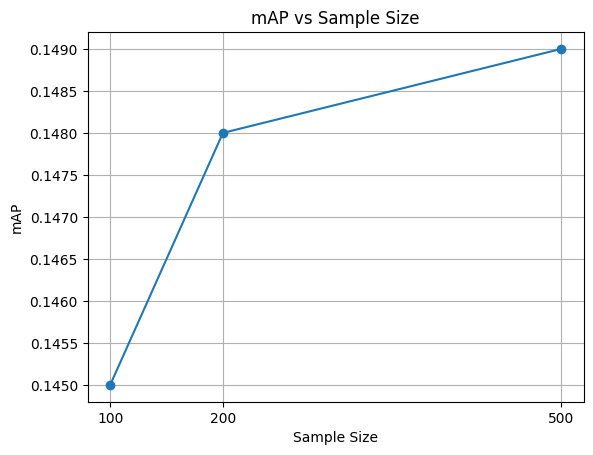

In [16]:
sample_sizes = [100, 200, 500]   #Samples
mAP_values = [0.145, 0.148, 0.149]  #  mAP values

# Plot the graph
plt.plot(sample_sizes, mAP_values, marker='o', linestyle='-')
plt.title('mAP vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('mAP')
plt.grid(True)
plt.xticks(sample_sizes)
plt.show()
